# Imports and loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from ESN.ESN import ESN, LCESN, EESN
from MackeyGlass.MackeyGlassGenerator import run
from Helper.utils import nrmse

data = np.array(run(21100)).reshape(-1, 1)
split = 20000
X_train = data[:split-1]
y_train = data[1:split]
valid_data = data[split:].squeeze()

data_mean = np.mean(data.squeeze())

DONE


# Basic ESN experiments

In [2]:
# baseline ESN 
esn = ESN(1, 1, 1000, echo_param=0.85, regulariser=1e-6)
esn.initialize_input_weights(scale=1.0)
esn.initialize_reservoir_weights(spectral_scale=1.25)
esn.train(X_train, y_train)

# generative tests
u_n = data[split-1]
esn_outputs = []
for _ in range(len(valid_data)):
    u_n = esn.forward(u_n)
    esn_outputs.append(u_n)
    
esn_outputs = np.array(esn_outputs).squeeze()

ESN got 0.8027 NRMSE


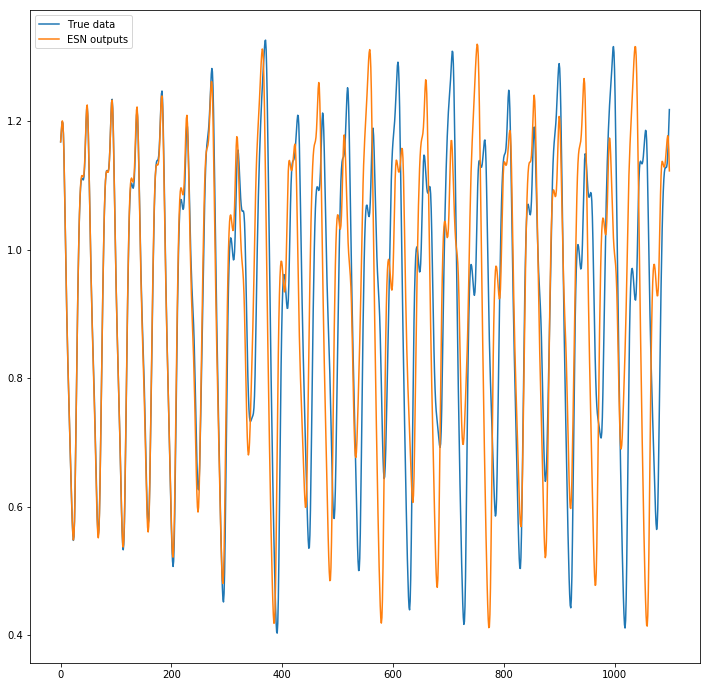

In [3]:
esn_nrmse = nrmse(valid_data, esn_outputs, data_mean)
print('ESN got %.4f NRMSE' % esn_nrmse)
xs = range(len(valid_data))

f, ax = plt.subplots(figsize=(12, 12))
ax.plot(xs, valid_data, label='True data')
ax.plot(xs, esn_outputs, label='ESN outputs')
#ax.plot(xs, [valid_mean]*len(xs), label='True data mean', linestyle='--', color='red')

plt.legend()
plt.show()

# LCESN experiments

In [4]:
all_results = dict()

In [14]:
echo_params = 0.85
regulariser = 1e-5
num_reservoirs = 5
reservoir_sizes = [int(np.ceil(1000. / num_reservoirs))]*num_reservoirs
in_weights = {'strategies': 'binary', 'scales': 0.2, 'offsets': 0.5}
res_weights = {'strategies': 'uniform', 'spectral_scales': 1., 'offsets': 0.5}
n_runs = 20

assert sum(reservoir_sizes) == 1000

results = []
for run_num in range(n_runs):
    print('Run %d' % (run_num+1))
    # create and train LCESN
    lcesn = LCESN(1, 1, num_reservoirs, reservoir_sizes, echo_params, 
                  regulariser=regulariser)
    lcesn.initialize_input_weights(
        strategies=in_weights['strategies'], scales=in_weights['scales'],
        offsets=in_weights['offsets']
    )
    lcesn.initialize_reservoir_weights(
        strategies=res_weights['strategies'], spectral_scales=res_weights['spectral_scales'],
        offsets=res_weights['offsets']
    )
    lcesn.train(X_train, y_train)
    lcesn_outputs = []
    
    # generative tests
    u_n = data[split-1]
    for _ in range(len(valid_data)):
        u_n = lcesn.forward(u_n)
        lcesn_outputs.append(u_n)

    lcesn_outputs = np.array(lcesn_outputs).squeeze()
    
    error = nrmse(valid_data, lcesn_outputs, data_mean)
    print('NRMSE: %f\n' % error)
    results.append(error)
    

key = [
    'echo_params: %f' % echo_params, 'regulariser: %f' % regulariser,
    'num_reservoirs: %d' % num_reservoirs, 'reservoir_sizes: %s' % reservoir_sizes,
    'in_weights: %s' % in_weights.items(), 'res_weights: %s' % res_weights,
    'n_runs: %d' % n_runs
]
for i in range(len(key)-1):
    key[i] += '\n'
key = ''.join(key)

if key not in all_results.keys():
    all_results[key] = []
    
all_results[key].extend(results)

pkl.dump(all_results, open('Results/LCESN/7_March.p', 'wb'))

Run 1
NRMSE: 0.754465

Run 2
NRMSE: 0.533263

Run 3
NRMSE: 0.657666

Run 4
NRMSE: 0.706536

Run 5
NRMSE: 0.872748

Run 6
NRMSE: 0.715016

Run 7
NRMSE: 0.862786

Run 8
NRMSE: 0.557971

Run 9
NRMSE: 1.191486

Run 10
NRMSE: 0.794733

Run 11
NRMSE: 0.839275

Run 12
NRMSE: 0.756817

Run 13
NRMSE: 0.571713

Run 14
NRMSE: 0.665261

Run 15
NRMSE: 189.003060

Run 16
NRMSE: 0.514789

Run 17
NRMSE: 1.061820

Run 18
NRMSE: 0.882196

Run 19
NRMSE: 541983331263348574519296.000000

Run 20
NRMSE: 31.324417



# State Histograms

In [ ]:
n_bins = 100
state_hist, state_bins = np.histogram(esn_state.squeeze(), bins=n_bins)
data_hist, data_bins = np.histogram(data[:1000].squeeze(), bins=n_bins)

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(16, 8))
ax1.set_title('Reservoir states')
ax2.set_title('First 1000 data points')

ax1.bar(state_bins[:-1], state_hist)
ax2.bar(data_bins[:-1], data_hist)
plt.show()

In [ ]:
f, axarr = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(16, 16))

for reservoir in lcesn.reservoirs:
    state = reservoir.state.squeeze()
    st_hist, st_bins = np.histogram(state, bins=n_bins)
    i = reservoir.idx
    
    
    r, c = i / 2, i % 2
    axarr[r][c].bar(st_bins[:-1], st_hist)
    axarr[r][c].set_title('Reservoir %d states' % i)
    
axarr[-1][-1].bar(data_bins[:-1], data_hist)
axarr[-1][-1].set_title('First 1000 data points')
plt.show()